# VarClump2D: Agglomeration test


In [1]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

## Loading data 2D: Stacked on frequency

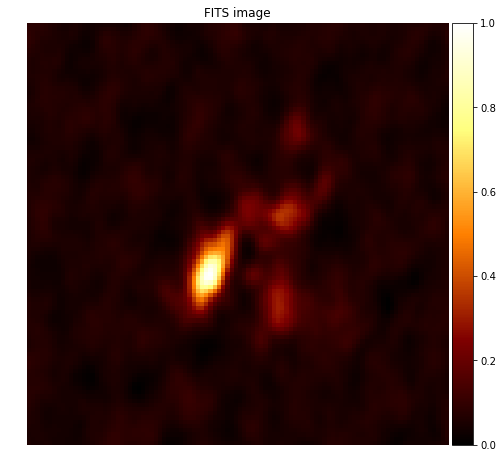

In [2]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [4]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.thresholded_image_plot>

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^2} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^2}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i,y_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

# Experiments: With  `base_level=RMS`
The following instances are tests with different settings combinations for: square_c

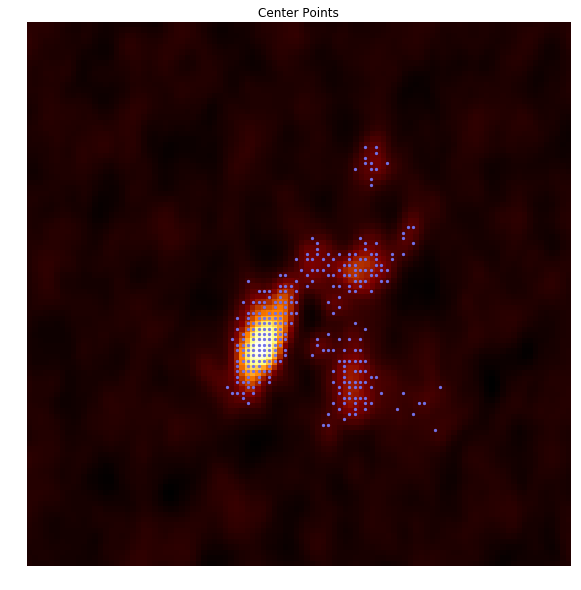

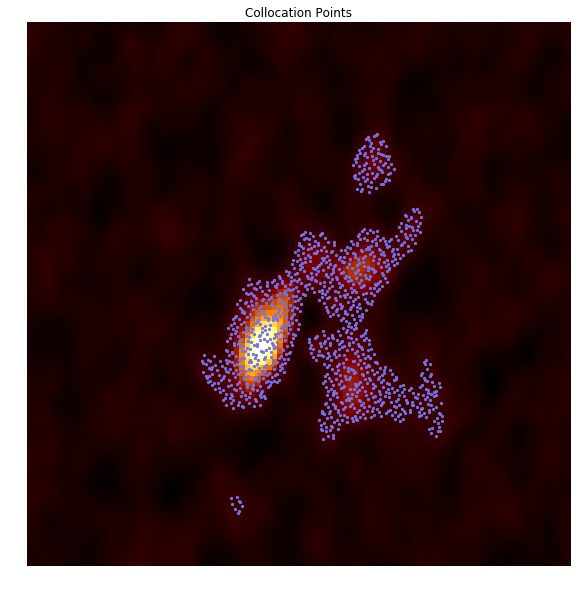

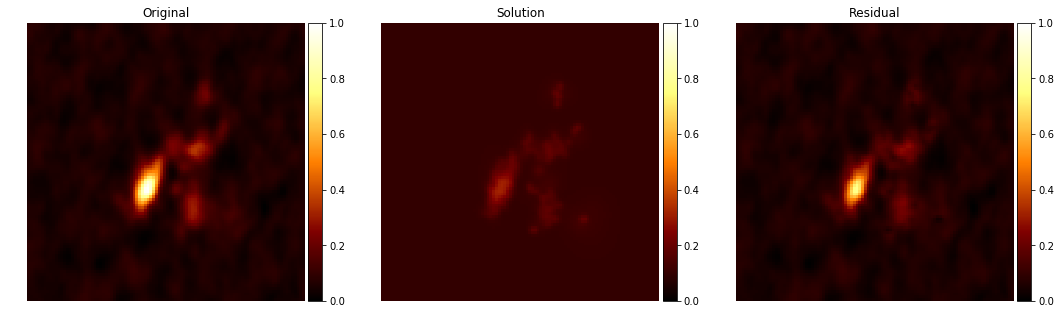

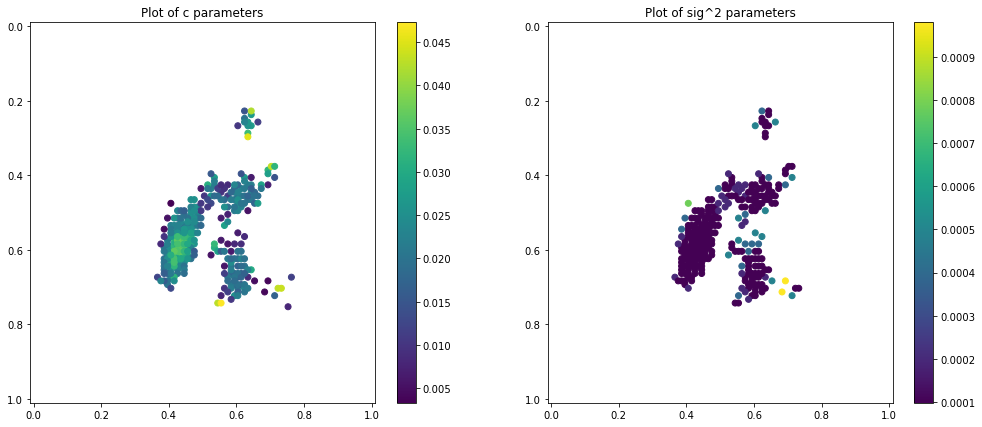

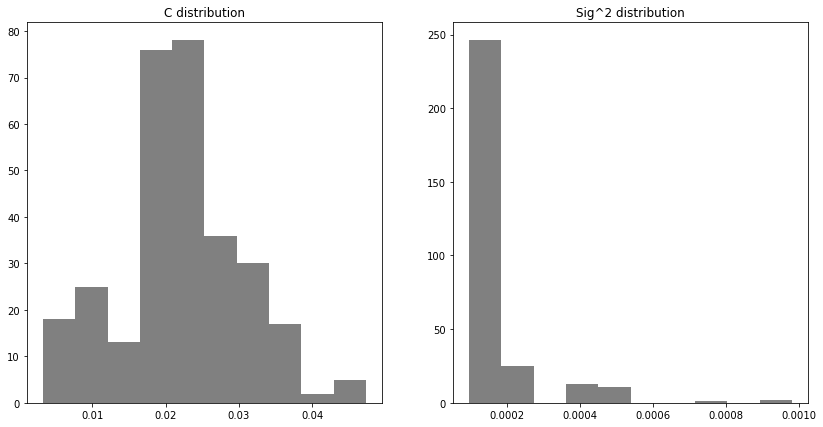

In [5]:
### # Approach 1
##########################################
Nc = 300
Nb = 0
Ne = 4*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=7.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_generation(Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 120100.
nfev: 120109

Residual stats:
Residual RMS: 0.10108869696082853
Residual Variance: 1.919666717326582e-05
Residual Entropy: 7.11143499403422
Total elapsed time: 433.81300687789917 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.21225157356498323
Mean min distance between collocation and center points: 0.011840438825876647

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.0673534340673322
Max min distance in the (standarized) parameters space: 0.4587173562332812


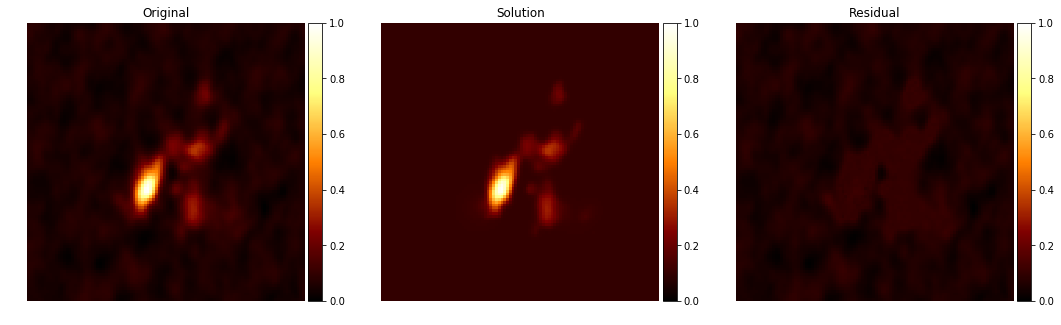

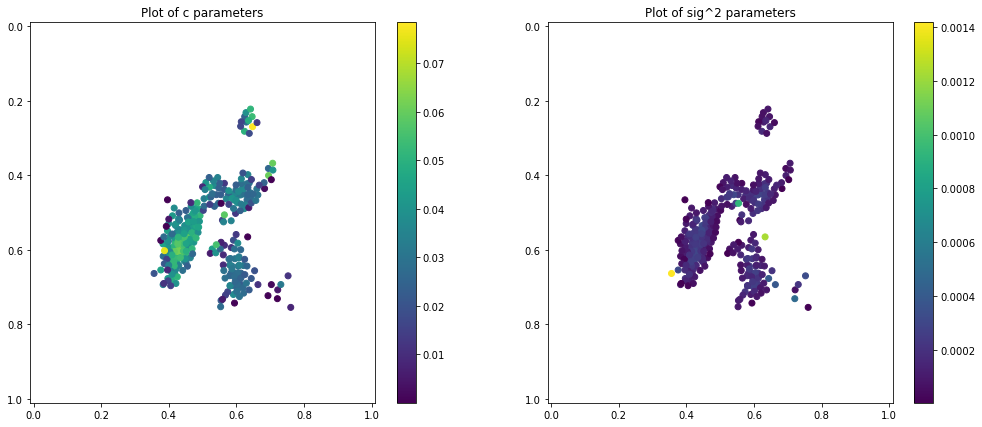

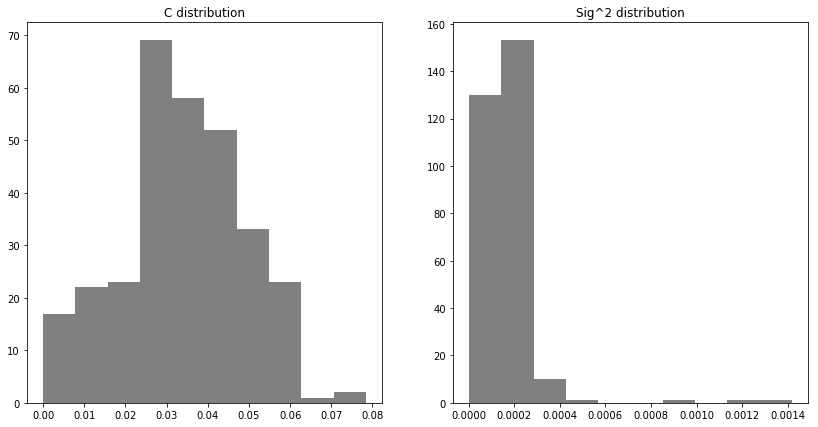

In [6]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [7]:
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

components_dict00 = gaussian_reduction(c, mu, sig, n_comp=1, verbose=False)
components_dict01 = gaussian_reduction(w, mu, sig, n_comp=1, verbose=True)

Merged components 209 and 294 with 2.950911500431154e-13 dissimilarity
Merged components 296 and 297 with 1.9618032755006174e-09 dissimilarity
Merged components 205 and 284 with 6.240142795407633e-09 dissimilarity
Merged components 176 and 285 with 4.437953471997002e-08 dissimilarity
Merged components 188 and 201 with 8.791568207721395e-08 dissimilarity
Merged components 164 and 265 with 1.8628457661731642e-07 dissimilarity
Merged components 65 and 136 with 2.1283248566555772e-07 dissimilarity
Merged components 223 and 226 with 2.1582860999791453e-07 dissimilarity
Merged components 255 and 287 with 2.884865665052083e-07 dissimilarity
Merged components 58 and 124 with 2.906774478682965e-07 dissimilarity
Merged components 200 and 259 with 3.8388045046426454e-07 dissimilarity
Merged components 104 and 201 with 4.108606976683291e-07 dissimilarity
Merged components 205 and 227 with 5.445851659277998e-07 dissimilarity
Merged components 71 and 157 with 5.567338438557719e-07 dissimilarity
Merg

In [8]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict00), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>

In [9]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>

In [10]:
components_dict02 = gaussian_reduction(w, mu, sig, n_comp=1, metric=ISD_dissimilarity, verbose=True)

Merged components 176 and 239 with -0.06379133619512899 dissimilarity
Merged components 292 and 298 with -0.06749065970062405 dissimilarity
Merged components 295 and 297 with -0.06251593044074094 dissimilarity
Merged components 283 and 296 with -0.056109263902696445 dissimilarity
Merged components 285 and 295 with -0.042789480098869064 dissimilarity
Merged components 201 and 234 with -0.042171238649919264 dissimilarity
Merged components 124 and 293 with -0.039970849406756166 dissimilarity
Merged components 124 and 133 with -0.03659099312555125 dissimilarity
Merged components 226 and 290 with -0.03583464469103077 dissimilarity
Merged components 207 and 289 with -0.034257377324939824 dissimilarity
Merged components 261 and 289 with -0.03225238849342351 dissimilarity
Merged components 233 and 272 with -0.028351537643978016 dissimilarity
Merged components 134 and 184 with -0.010830615222964014 dissimilarity
Merged components 280 and 286 with -0.015047781668663716 dissimilarity
Merged compo